# Bike count forecasting using FFNN

In [1]:
import pandas as pd
import numpy as np
import os
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing methods
from sklearn.preprocessing import StandardScaler

# accuracy measures and data spliting
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# deep learning libraries
from keras.models import Input, Model
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU
from keras.layers import Conv1D, MaxPooling1D
from keras import layers
from keras import losses
from keras import optimizers
from keras import metrics
from keras import callbacks
from keras import initializers

Using TensorFlow backend.


In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 15, 7

## 1. Data import and basic analysis

In [3]:
DATADIR = '../data/bike/'
MODELDIR = '../checkpoints/bike-sharing/ffnn/'

data_path = os.path.join(DATADIR, 'bike-sharing-processed.csv')
data = pd.read_csv(data_path)

In [4]:
data.set_index('date', inplace=True)
data.sort_index(inplace=True)
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,HurricaneSandy
date,,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985,0
2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0
2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349,0
2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562,0
2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600,0


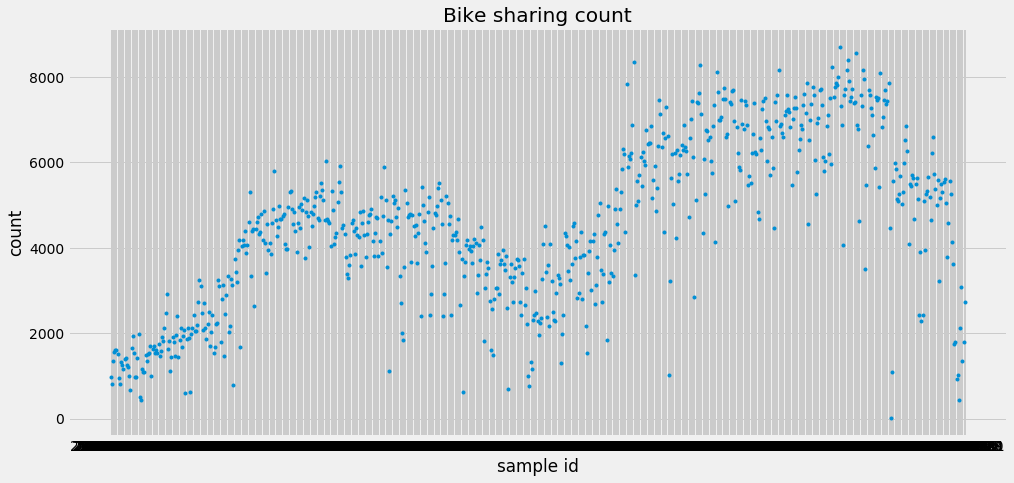

In [5]:
plt.plot(data.cnt, '.')
plt.title('Bike sharing count')
plt.xlabel('sample id')
plt.ylabel('count')
plt.show()

## 2. Data preparation

In [6]:
y = data[['cnt']].copy()
X = data.drop(columns=['cnt'], axis=1)

print(f'X and y shape:')
print(X.shape, y.shape)

# date selection
datelist = data.index.unique()

# two month data for testset
print(f'Test start date: {datelist[-61]}')

# Train test split : last 60 days for test set

X_train = X[X.index < datelist[-61]]
X_test = X[X.index >= datelist[-61]]

y_train = y[y.index < datelist[-61]]
y_test = y[y.index >= datelist[-61]]


print(f'Size of train and test set respectively:')
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

X and y shape:
(731, 12) (731, 1)
Test start date: 2012-11-01
Size of train and test set respectively:
(670, 12) (61, 12) (670, 1) (61, 1)


## 3. Model building

In [7]:
def model_evaluation(y_train, y_test, y_train_pred, y_test_pred):
    
    # MAE and NRMSE calculation
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_nrmse = train_rmse/np.std(y_train.values)

    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_nrmse = test_rmse/np.std(y_test.values)

    print(f'Training MAE: {np.round(train_mae, 3)}')
    print(f'Trainig NRMSE: {np.round(train_nrmse, 3)}')
    print()

    print(f'Test MAE: {np.round(test_mae)}')
    print(f'Test NRMSE: {np.round(test_nrmse)}')
    
    return

In [8]:
def model_training(X_train, X_test, y_train, model, batch=8, name='m'):
    start = time.time()
    loss = losses.mean_squared_error
    opt = optimizers.Adam()
    metric = [metrics.mean_absolute_error]
    model.compile(loss=loss, optimizer=opt, metrics=metric)

    callbacks_list = [callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)]

    history = model.fit(X_train, y_train, 
                        epochs=100, 
                        batch_size=batch, 
                        verbose=0,
                        shuffle=False,
                        callbacks=callbacks_list
                       )

    # save model weights and 
    if os.path.exists(MODELDIR):
        pass
    else:
        os.makedirs(MODELDIR)
    m_name = name + str('.h5')
    w_name = name + str('_w.h5')
    model.save(os.path.join(MODELDIR, m_name))
    model.save_weights(os.path.join(MODELDIR, w_name))

    # prediction
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    end = time.time()
    time_taken = np.round((end-start), 3)
    print(f'Time taken to complete the process: {time_taken} seconds')
    
    return y_train_pred, y_test_pred, history

In [9]:
features = X_train.shape[1]
xavier = initializers.glorot_normal()

### FFNN - v1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 39        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 4.398 seconds
Training MAE: 1462.001
Trainig NRMSE: 0.918

Test MAE: 1767.0
Test NRMSE: 1.0


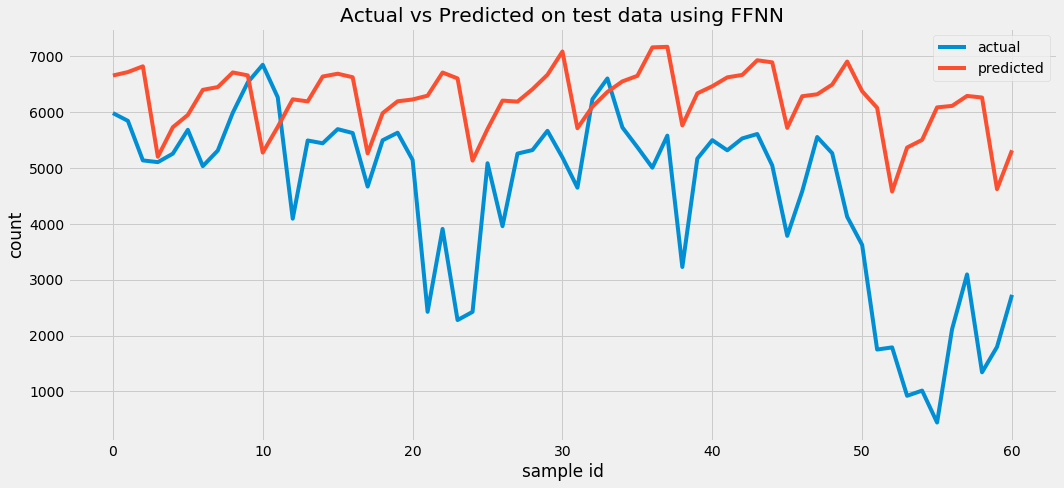

In [10]:
model = Sequential()

model.add(Dense(3, input_dim = features, kernel_initializer=xavier, 
                activation='relu'))
model.add(Dense(5, kernel_initializer=xavier, 
                activation='relu'))

model.add(Dense(1, kernel_initializer=xavier))

model.summary()

y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=16, name='fc-v1')

model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.plot(y_test.values, label='actual')
plt.plot(y_test_pred, label='predicted')
plt.ylabel('count')
plt.xlabel('sample id')
plt.title('Actual vs Predicted on test data using FFNN')
plt.legend()
plt.tight_layout()
plt.show()

## FFNN - v2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 8.612 seconds
Training MAE: 737.417
Trainig NRMSE: 0.494

Test MAE: 1485.0
Test NRMSE: 1.0


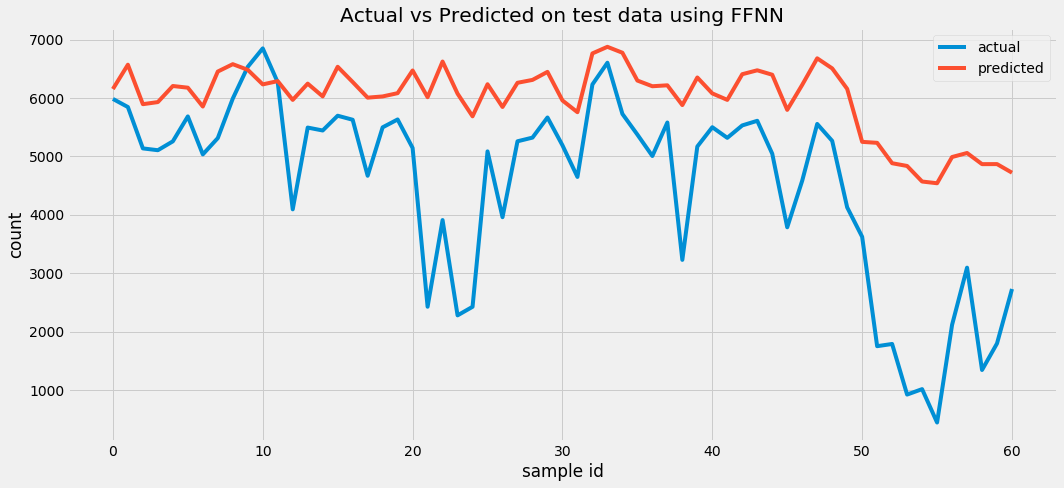

In [11]:
model = Sequential()

model.add(Dense(8, input_dim = features, kernel_initializer=xavier, 
                activation='relu'))
model.add(Dense(16, kernel_initializer=xavier, activation='relu'))
model.add(Dense(16, kernel_initializer=xavier, activation='relu'))

model.add(Dense(1, kernel_initializer=xavier))

model.summary()

y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=8, name='fc-v2')

model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.plot(y_test.values, label='actual')
plt.plot(y_test_pred, label='predicted')
plt.ylabel('count')
plt.xlabel('sample id')
plt.title('Actual vs Predicted on test data using FFNN')
plt.legend()
plt.tight_layout()
plt.show()

## FFNN - v3 (final model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_9 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 17        
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 32.214 seconds
Training MAE: 673.971
Trainig NRMSE: 0.462

Test MAE: 1232.0
Test NRMSE: 1.0


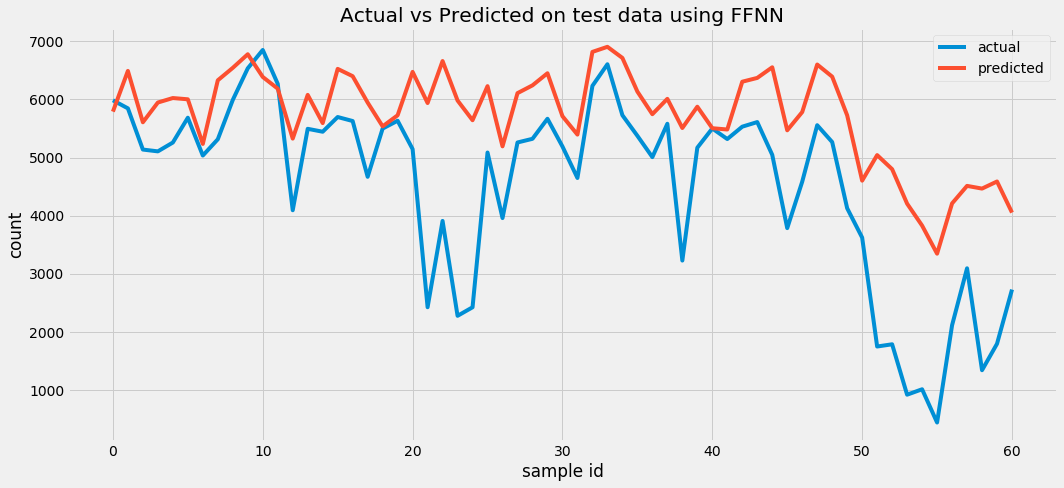

In [12]:
model = Sequential()

model.add(Dense(8, input_dim = features, kernel_initializer=xavier, 
                activation='relu'))
model.add(Dense(16, kernel_initializer=xavier, activation='relu'))
model.add(Dense(16, kernel_initializer=xavier, activation='relu'))

model.add(Dense(1, kernel_initializer=xavier))

model.summary()

y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=2, name='fc-v3')

model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.plot(y_test.values, label='actual')
plt.plot(y_test_pred, label='predicted')
plt.ylabel('count')
plt.xlabel('sample id')
plt.title('Actual vs Predicted on test data using FFNN')
plt.legend()
plt.tight_layout()
plt.show()

## FFNN - v4

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_13 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 1,481
Trainable params: 1,481
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 33.544 seconds
Training MAE: 680.949
Trainig NRMSE: 0.468

Test MAE: 1248.0
Test NRMSE: 1.0


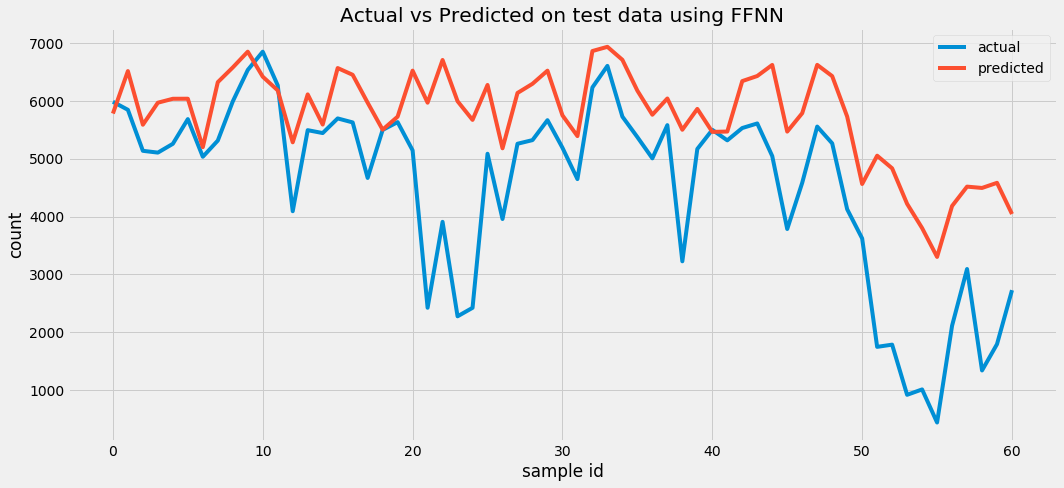

In [13]:
model = Sequential()

model.add(Dense(8, input_dim = features, kernel_initializer=xavier, 
                activation='relu'))
model.add(Dense(32, kernel_initializer=xavier, activation='relu'))
model.add(Dense(32, kernel_initializer=xavier, activation='relu'))

model.add(Dense(1, kernel_initializer=xavier))

model.summary()

y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=2, name='fc-v4')

model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.plot(y_test.values, label='actual')
plt.plot(y_test_pred, label='predicted')
plt.ylabel('count')
plt.xlabel('sample id')
plt.title('Actual vs Predicted on test data using FFNN')
plt.legend()
plt.tight_layout()
plt.show()

## FFNN - v5

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_17 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_18 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_19 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 2,537
Trainable params: 2,537
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 36.941 seconds
Training MAE: 764.569
Trainig NRMSE: 0.53

Test MAE: 1382.0
Test NRMSE: 1.0


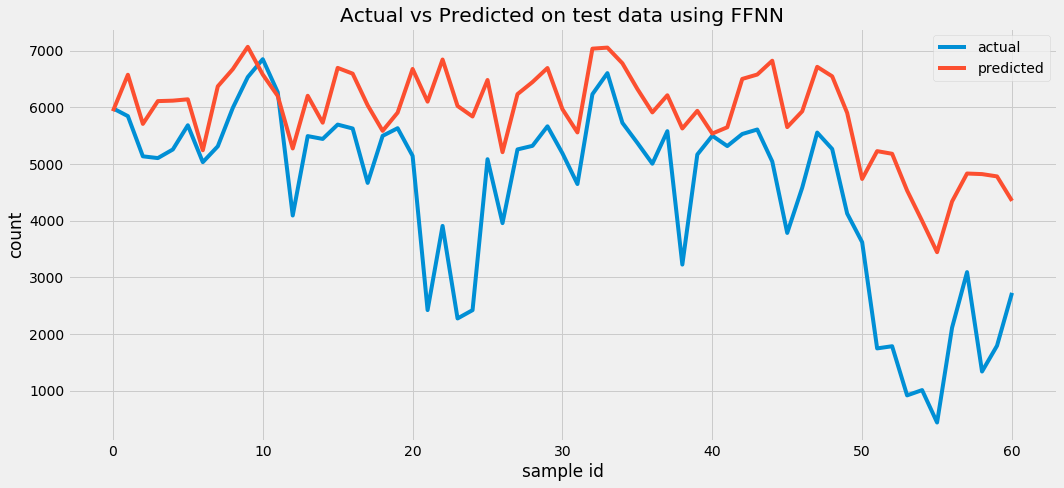

In [14]:
model = Sequential()

model.add(Dense(8, input_dim = features, kernel_initializer=xavier, 
                activation='relu'))
model.add(Dense(32, kernel_initializer=xavier, activation='relu'))
model.add(Dense(32, kernel_initializer=xavier, activation='relu'))
model.add(Dense(32, kernel_initializer=xavier, activation='relu'))

model.add(Dense(1, kernel_initializer=xavier))

model.summary()

y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=2, name='fc-v5')

model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.plot(y_test.values, label='actual')
plt.plot(y_test_pred, label='predicted')
plt.ylabel('count')
plt.xlabel('sample id')
plt.title('Actual vs Predicted on test data using FFNN')
plt.legend()
plt.tight_layout()
plt.show()

### FFNN - v6

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_22 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_23 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 9         
Total params: 665
Trainable params: 665
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 3.082 seconds
Training MAE: 1252.682
Trainig NRMSE: 0.789

Test MAE: 1646.0
Test NRMSE: 1.0


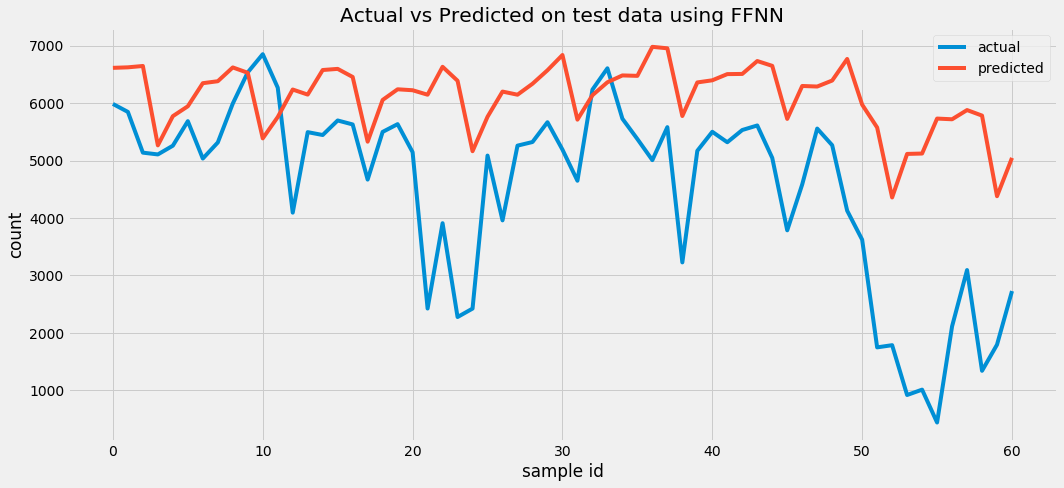

In [15]:
model = Sequential()

model.add(Dense(8, input_dim = features, kernel_initializer=xavier, 
                activation='relu'))
model.add(Dense(16, kernel_initializer=xavier, activation='relu'))
model.add(Dense(16, kernel_initializer=xavier, activation='relu'))
model.add(Dense(8, kernel_initializer=xavier, activation='relu'))

model.add(Dense(1, kernel_initializer=xavier))

model.summary()

y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=32, name='fc-v6')

model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.plot(y_test.values, label='actual')
plt.plot(y_test_pred, label='predicted')
plt.ylabel('count')
plt.xlabel('sample id')
plt.title('Actual vs Predicted on test data using FFNN')
plt.legend()
plt.tight_layout()
plt.show()